# Target Capture Efficiency and Sequence Divergence


For the Pleurocarpous Moss Tree of Life project, we designed a set of target capture probes from 1KP data and the Physcomitrella proteome. Genes were selected from 1KP orthogroups if there was a Physcomitrella copy and at least four pleurocarpous mosses in the orthogroup. For each selected gene, MycroArray probes were designed from one pleurocarpous moss gene and the orthologous Physcomitrella gene.

For our moss backbone phylogeny, we were able to successfully recover about 100 genes from about 130 moss species. Capture efficiency was sufficient in all peristomate mosses, but very few genes were captured from Sphagnum, and none were captured from liverworts. In the heatmap below, columns represent genes, rows represent samples. The shading in each cell represents the length of the gene recovered by HybPiper, as a percentage of the target sequence length (darker is more complete).

![hi](img/moss_backbone_heatmap.png)

Most of the white horizontal stripes are mosses outside the Bryoposida (*Sphagnum*, *Andreaea*, *Takakia*) or nematodontous mosses (*Diphyscium*, *Buxbaumia*, *Tetraphis*), or liverworts.

Here we investigate exactly how "divgerged" sequences can be before we can no longer capture them efficiently. What is the pratical limit for targeted sequence capture?

#### Reading in the data

This table contains four columns: 

    Gene Name
    Sequence Accession
    Target Type (Physcomitrella or Pleurocarp)
    Percent Dissimilarity
    
Dissimilarity was calculated from a pairwise sequence alignment between the captured sequence and the target sequence, not including gap characters. Captured sequences that were < 50% of the length of the target sequence were removed. The first task is to find the maximum distance between each captured sequence and a target sequence.   

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
minimum_distances = []
capture_distance_fn = "/Users/mjohnson/Desktop/Projects/moss_backbone/nuclear/enrichment/distances.txt"
capture_distance = open(capture_distance_fn)
while True:
    line1=capture_distance.readline().rstrip().split()
    line2=capture_distance.readline().rstrip().split()
    if not line2: break
    for line in (line1,line2):
        if not line[2].startswith("Physco"):
            line[2] = "Pleurocarp-{}".format(line[0])   
    try:
        line1[-1]=float(line1[-1])
        line2[-1]=float(line2[-1])
        min_pdist = np.array((line1[-1],line2[-1])).argmin()
    except ValueError:
        continue
    
    if min_pdist:
        minimum_distances.append(line2)
    else:
        minimum_distances.append(line1)
capture_distance.close()    
capture_distance_df = pd.DataFrame.from_records(minimum_distances,columns=["Gene","Species","Target","Distance"])
capture_distance_df["IsOnekp"] = capture_distance_df.Species.str.contains("onekp")

We defined a column "IsOneKP" because we used sequences from the OneKP database to fill in "gaps" in our phylogeny, especially where target capture was inefficient. We will make separate calculations for sequences which were obtained through targeted sequencing from those obtained from onekp. First, a histogram of all pairwise distances between sequences and targets. 

In [22]:
capture_distance_df[(capture_distance_df.Gene == "10176") & 
                    (capture_distance_df.Species.str.lower().str.startswith("takakia"))]

,Gene,Species,Target,Distance,IsOnekp
457,10176,Takakia-4343a,Pleurocarp-10176,0.277467,False
459,10176,Takakia-ceratophylla-3743,Pleurocarp-10176,0.253359,False
590,10176,takakia-onekp,Pleurocarp-10176,0.277467,True


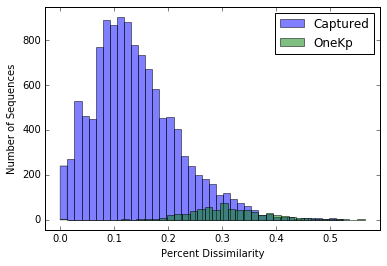

In [2]:
groups = capture_distance_df.groupby("IsOnekp")
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.hist(group.Distance, bins=40,alpha=0.5)
ax.legend(["Captured","OneKp"])
plt.xlabel("Percent Dissimilarity")
plt.ylabel("Number of Sequences")
plt.rcParams['figure.figsize'] = (3, 4)
plt.show()

It is obvious from the histogram that captured sequence was most effective when the percent dissimilarity is less than 25%. The sequences from 1KP are skewed to have higher divergence because these are from species that were hard to obtain through sequence capture. 

Normally it would be tough to tell whether or not a sequence could not be recovered because it is too divergent, or because of some other technical reason. Howevever, we can actually test this because of the data from 1KP. For some species, we have data from both sequence capture and onekp. For these species we can make a direct comparison to see where the "true" divergence is.

In the example below, all sequences attributed to some mosses with high divergence to the targets are summarized based on whether they are from OneKP (True) or capture data (False). It's clear that although the averaage dissimilarity between any sequence and a target sequence is about 30%, recovering a sequence using targeted capture with > 30% divergence is not as likely. 


/usr/local/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


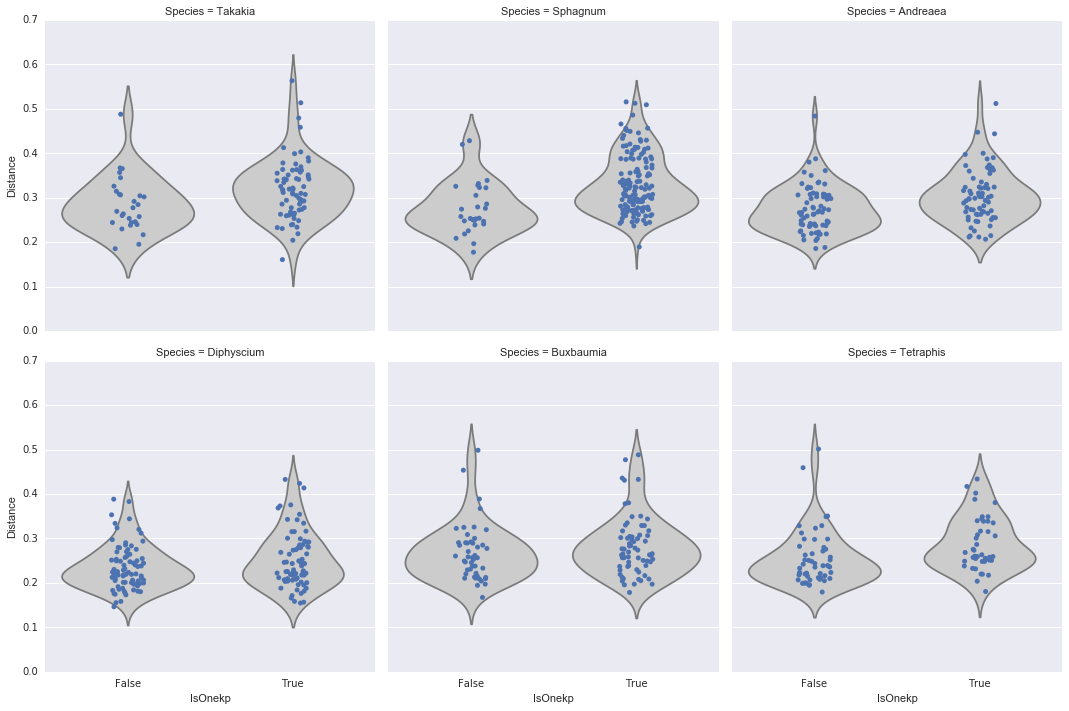

In [31]:
import seaborn as sns
#Set up a data frame containing only the four divergent species, from both capture and OneKP Data
takakia = capture_distance_df[(capture_distance_df.Species.str.upper().str.contains("TAKAKIA"))]
takakia.Species="Takakia"
diphyscium = capture_distance_df[(capture_distance_df.Species.str.lower().str.contains("diphyscium"))]
diphyscium.Species="Diphyscium"
buxbaumia = capture_distance_df[(capture_distance_df.Species.str.lower().str.contains("buxbaumia"))]
buxbaumia.Species="Buxbaumia"
tetraphis = capture_distance_df[(capture_distance_df.Species.str.lower().str.contains("tetraphis"))]
tetraphis.Species = "Tetraphis"
andreaea = capture_distance_df[(capture_distance_df.Species.str.lower().str.contains("andrea"))]
andreaea.Species = "Andreaea"
sphagnum = capture_distance_df[(capture_distance_df.Species.str.lower().str.startswith("sphagnum"))]
sphagnum.Species = "Sphagnum"
#Combine the dataframes
divergent_mosses = pd.concat([takakia,sphagnum,andreaea,diphyscium,buxbaumia,tetraphis])
divergent_mosses.drop(["Gene","Target"],1,inplace=True)
divergent_mosses

#Plot the data
g = sns.FacetGrid(divergent_mosses,col="Species",size=5,aspect=1,col_wrap=3)
g = g.map(sns.violinplot,"IsOnekp","Distance",bins=20,color=".8",inner=None)
g = g.map(sns.stripplot,"IsOnekp","Distance",jitter=True)

### Conclusions

Based on the data collected from the mosses there is a clear pattern about when to expect efficient sequence capture. Good sequence recovery should be expected with a sequence divergence as much as 25%, and a large drop-off in gene recovery rate should be expected wth a sequence divergence of more than 30%.



In [39]:
g.savefig("/Users/mjohnson/Desktop/Projects/moss_backbone/nuclear/enrichment/Hybseq_vs_OneKP.svg")

In [5]:
sphagnum_1kp=capture_distance_df[(capture_distance_df.Species.str.startswith("sphagnum")) & 
                    (capture_distance_df.Target.str.startswith("Physco"))].Gene.value_counts()
sphagnum_hybseq=capture_distance_df[(capture_distance_df.Species.str.startswith("Sphagnum")) & 
                    (capture_distance_df.Target.str.startswith("Physco"))].Gene.value_counts()

In [12]:
takakia_1kp=capture_distance_df[(capture_distance_df.Species.str.startswith("takakia")) & 
                    (capture_distance_df.Target.str.startswith("Physco"))].Gene.value_counts()
takakia_hybseq=capture_distance_df[(capture_distance_df.Species.str.startswith("Takakia")) & 
                    (capture_distance_df.Target.str.startswith("Physco"))].Gene.value_counts()

In [24]:
len(takakia[takakia.IsOnekp == False].Gene.value_counts())

21

In [37]:
median_sphagnum_onekp = sphagnum[sphagnum.IsOnekp == True].Distance.median()
numgenes_sphagnum_onekp = len(sphagnum[sphagnum.IsOnekp == True].Gene.value_counts())
median_sphagnum_hybseq = sphagnum[sphagnum.IsOnekp == False].Distance.median()
numgenes_sphagnum_hybseq = len(sphagnum[sphagnum.IsOnekp == False].Gene.value_counts())

print('''The number of Sphagnum genes recovered via OneKP was {} with a median PWD of {}.
    The number of Sphagnum genes recovered via Hybseq was {} with a median PWD of {}.\n'''.format(
        numgenes_sphagnum_onekp, median_sphagnum_onekp, numgenes_sphagnum_hybseq, median_sphagnum_hybseq))

The number of Sphagnum genes recovered via OneKP was 73 with a median PWD of 0.314833501514.
    The number of Sphagnum genes recovered via Hybseq was 20 with a median PWD of 0.253895508708.



In [38]:
median_takakia_onekp = takakia[takakia.IsOnekp == True].Distance.median()
numgenes_takakia_onekp = len(takakia[takakia.IsOnekp == True].Gene.value_counts())
median_takakia_hybseq = takakia[takakia.IsOnekp == False].Distance.median()
numgenes_takakia_hybseq = len(takakia[takakia.IsOnekp == False].Gene.value_counts())

print('''The number of takakia genes recovered via OneKP was {} with a median PWD of {}.
    The number of takakia genes recovered via Hybseq was {} with a median PWD of {}.\n'''.format(
        numgenes_takakia_onekp, median_takakia_onekp, numgenes_takakia_hybseq, median_takakia_hybseq))

The number of takakia genes recovered via OneKP was 70 with a median PWD of 0.31746695872599995.
    The number of takakia genes recovered via Hybseq was 21 with a median PWD of 0.2733643650265.

